In [1]:
spark

In [60]:
dir0 = '/home/cloudera/2.kkbox_churn/data01/big_table_01/has_expired/'
# infile = dir0 + '20a.train.field-select_correlation-0.7'
infile = dir0 + '20b.test.field-select_correlation-0.7'

df0 = spark.read.format('parquet').load(infile)

In [61]:
df0.dtypes

[('msno', 'string'),
 ('city', 'string'),
 ('gender', 'string'),
 ('registered_via', 'string'),
 ('init_date', 'string'),
 ('final_date', 'string'),
 ('has_long_gap', 'boolean'),
 ('has_expired', 'boolean'),
 ('last_pay_method', 'string'),
 ('auto_renew_mode', 'boolean'),
 ('pay_method_mode', 'string'),
 ('my_is_churn', 'boolean'),
 ('is_churn', 'boolean'),
 ('days_since_init_regist', 'int'),
 ('gaps_count', 'int'),
 ('last_plan_days', 'int'),
 ('last_discount', 'int'),
 ('last_paid_per_day', 'double'),
 ('auto_renew_cnt_uniq', 'int'),
 ('discount_mode', 'int'),
 ('pay_method_cnt_uniq', 'int'),
 ('plan_days_cnt_uniq', 'int'),
 ('discount_per_sub_day', 'double'),
 ('w1_M75_D_Mtotal', 'double'),
 ('w1_M985_D_Mtotal', 'double'),
 ('w2_M75_D_Mtotal', 'double'),
 ('last4WeekOnLine', 'int'),
 ('w4_M25', 'int'),
 ('w4_M75', 'int'),
 ('w4_M985', 'int'),
 ('w4_Mtotal', 'int'),
 ('w4_M50_D_Mtotal', 'double'),
 ('w4_M100_D_Mtotal', 'double'),
 ('w4_Munq_D_Mtotal', 'double'),
 ('w4_M985_D_Mtotal',

In [62]:
cols_categorical = [p[0]  for p in df0.dtypes  if p[1] in ['string', 'boolean']]
cols_categorical

['msno',
 'city',
 'gender',
 'registered_via',
 'init_date',
 'final_date',
 'has_long_gap',
 'has_expired',
 'last_pay_method',
 'auto_renew_mode',
 'pay_method_mode',
 'my_is_churn',
 'is_churn']

In [63]:
cols_categ_select = [
#     'msno',
    'city',
#     'gender',
    'registered_via',
#     'init_date',
#     'final_date',
    'has_long_gap',
    'has_expired',
    'last_pay_method',
    'auto_renew_mode',
    'pay_method_mode',
    'my_is_churn',
    'is_churn'
]

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import math

def plot_categorical_value_counts(df, cols, nFigCols):
    ''' Return fig '''
    nFigRows = int(math.ceil(len(cols)/nFigCols))
    fig = plt.figure()
    for i in range(len(cols)):
        ax = fig.add_subplot(nFigRows, nFigCols, i+1)

        values = pd.Series(df0.rdd.map(lambda row: row[cols[i]]).collect())
        value_freqs = values.value_counts().sort_index()

        value_freqs.plot.bar(ax=ax, color='#0070c0')
        ax.set(title=cols[i], ylabel='count')

        fig.subplots_adjust(wspace=0.3, hspace=0.55)
    return fig

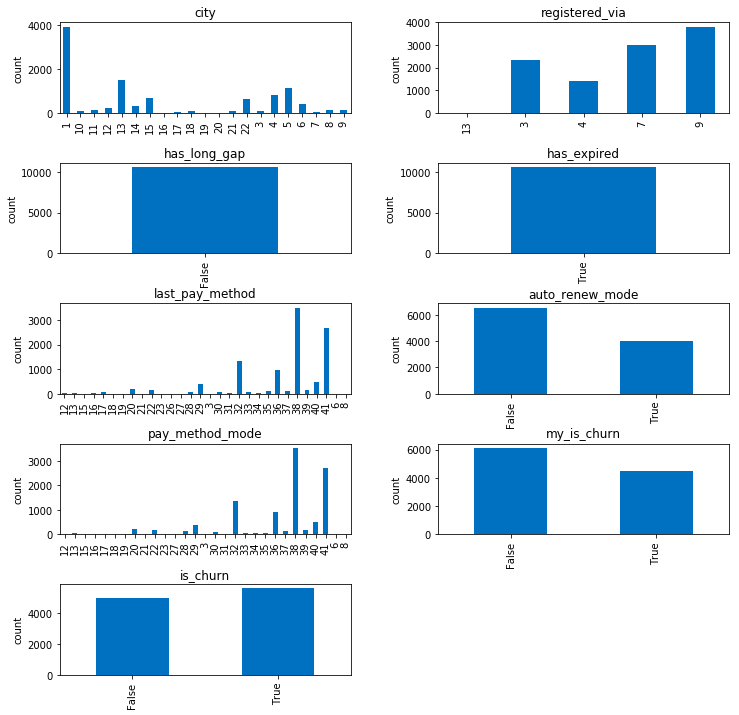

In [65]:
fig = plot_categorical_value_counts(df0, cols_categ_select, 2)
fig.set_size_inches(12, 12)
plt.show()

In [66]:
cols_categ_select = [
#     'msno',
    'city',
#     'gender',
    'registered_via',
#     'init_date',
#     'final_date',
#     'has_long_gap',  # all False
#     'has_expired',   # all True
    'last_pay_method',
    'auto_renew_mode',
    'pay_method_mode',
    'my_is_churn',
    'is_churn'
]

# transform

In [67]:
# city
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def group_cities(city):
    if '10' <= city <= '12':
        return '10-12'
    elif '16' <= city <= '21':
        return '16-21'
    elif city == '3' or '7' <= city <= '9':
        return '03/07-09'
    else :
        return city.zfill(2)

udf_group_cities = udf(group_cities, StringType())    

df0 = df0.withColumnRenamed('city', 'city_orig') \
      .withColumn('city', udf_group_cities('city_orig')) \
      .drop('city_orig')

In [68]:
# last_pay_method
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def group_pay_method(pay_method):
    if pay_method in ['20','22','29','32','36','38','39','40','41']:
        return pay_method
    else:
        return 'other'

udf_group_pay_method = udf(group_pay_method, StringType())    

df0 = df0.withColumnRenamed('last_pay_method', 'last_pay_method_orig') \
      .withColumn('last_pay_method', udf_group_pay_method('last_pay_method_orig')) \
      .drop('last_pay_method_orig')

In [69]:
# pay_method_mode
df0 = df0.withColumnRenamed('pay_method_mode', 'pay_method_mode_orig') \
      .withColumn('pay_method_mode', udf_group_pay_method('pay_method_mode_orig')) \
      .drop('pay_method_mode_orig')

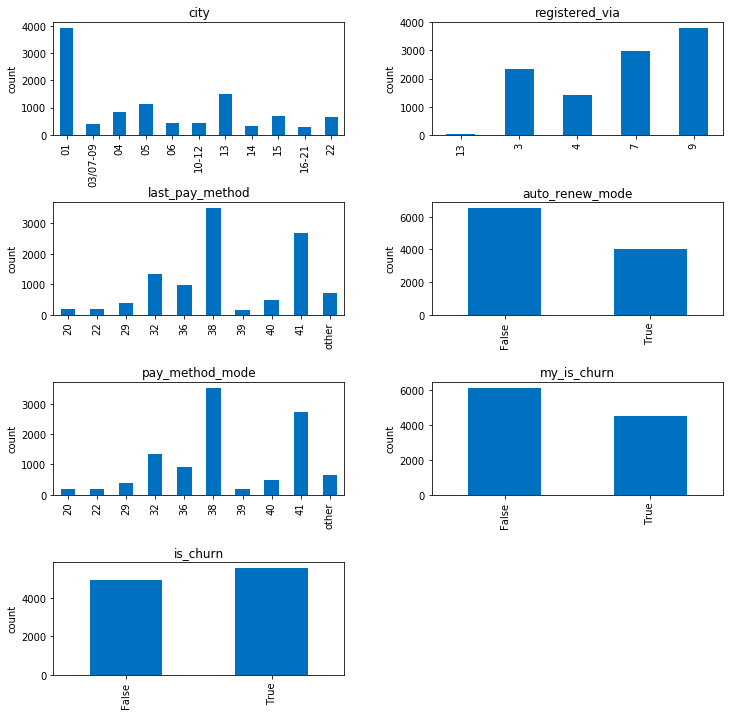

In [70]:
fig = plot_categorical_value_counts(df0, cols_categ_select, 2)
fig.set_size_inches(12, 8)
fig.subplots_adjust(hspace=0.6)
fig.set_size_inches(12, 12)
plt.show()

# select

In [71]:
df0.select(cols_categ_select).show(10)

+--------+--------------+---------------+---------------+---------------+-----------+--------+
|    city|registered_via|last_pay_method|auto_renew_mode|pay_method_mode|my_is_churn|is_churn|
+--------+--------------+---------------+---------------+---------------+-----------+--------+
|      04|             9|             38|          false|             38|      false|   false|
|      01|             7|             41|           true|             41|      false|   false|
|      01|             4|             36|          false|             36|       true|    true|
|      15|             3|          other|           true|          other|       true|    true|
|      01|             7|             41|           true|             41|      false|   false|
|      01|             3|             38|          false|             38|       true|    true|
|03/07-09|             7|             41|           true|             41|       true|    true|
|      01|             4|             36|         

In [72]:
df0.crosstab('last_pay_method', 'pay_method_mode') \
   .sort('last_pay_method_pay_method_mode').show()

+-------------------------------+---+---+---+----+---+----+---+---+----+-----+
|last_pay_method_pay_method_mode| 20| 22| 29|  32| 36|  38| 39| 40|  41|other|
+-------------------------------+---+---+---+----+---+----+---+---+----+-----+
|                             20|194|  0|  0|   0|  0|   0|  0|  0|   0|    0|
|                             22|  0|174|  0|   0|  0|   0|  0|  0|   0|    0|
|                             29|  0|  0|363|   2|  5|   8|  1|  2|   5|    5|
|                             32|  0|  0|  0|1331|  0|   0|  0|  0|   0|    0|
|                             36|  0|  1|  6|  18|883|  22|  5| 10|  13|    6|
|                             38|  9|  2| 12|   4| 13|3444|  2|  6|   6|   10|
|                             39|  0|  0|  0|   0|  0|   0|169|  0|   0|    0|
|                             40|  0|  0|  0|   2|  1|   4|  0|465|   2|    0|
|                             41|  0|  0|  0|   0|  0|   0|  0|  0|2685|    0|
|                          other|  0|  2|  5|   0|  

* last_pay_method and pay_method_mode are correlated

In [73]:
df0.crosstab('last_pay_method', 'registered_via').show()

+------------------------------+---+----+---+----+----+
|last_pay_method_registered_via| 13|   3|  4|   7|   9|
+------------------------------+---+----+---+----+----+
|                            40|  0| 128| 35|  24| 287|
|                            22|  0|  46| 23|   3| 102|
|                            32|  0| 280|109|  83| 859|
|                            36|  0| 306|177|  65| 416|
|                            39|  0|  59| 16|   5|  89|
|                            20|  0|  71| 59|   4|  60|
|                            38|  0|1152|769|  90|1497|
|                            29|  0| 136|147|  17|  91|
|                            41|  0|   0|  0|2678|   7|
|                         other| 13| 178| 89|  19| 400|
+------------------------------+---+----+---+----+----+



In [74]:
df0.crosstab('city', 'registered_via').show()

+-------------------+---+---+---+----+---+
|city_registered_via| 13|  3|  4|   7|  9|
+-------------------+---+---+---+----+---+
|           03/07-09|  0|120| 47|  51|162|
|                 15|  0|197| 88|  70|338|
|                 22|  0|199| 84|  40|328|
|                 13|  0|401|139| 124|834|
|                 05|  0|352|152|  99|527|
|                 04|  0|233|123|  89|389|
|              10-12|  0|139| 53|  47|206|
|                 06|  1|119| 62|  25|217|
|                 14|  0| 83| 27|  46|150|
|              16-21|  0|101| 38|  35|120|
|                 01| 12|412|611|2362|537|
+-------------------+---+---+---+----+---+



In [75]:
cols_categ_select = [
#     'msno',
    'city',
#     'gender',
    'registered_via',
#     'init_date',
#     'final_date',
#     'has_long_gap',  # all False
#     'has_expired',   # all True
#     'last_pay_method',  # correlated with pay_method_mode
    'auto_renew_mode',
    'pay_method_mode',
    'my_is_churn',
    'is_churn'
]

if 'msno' in cols_categ_select:
    cols_categ_select.remove('msno')
if 'my_is_churn' not in cols_categ_select:
    cols_categ_select.append('my_is_churn')
if 'is_churn' not in cols_categ_select:
    cols_categ_select.append('is_churn')
cols = ['msno'] + [c  for c in df0.columns  if c not in cols_categorical] + cols_categ_select

df1 = df0.select(cols)
df1.printSchema()

root
 |-- msno: string (nullable = true)
 |-- days_since_init_regist: integer (nullable = true)
 |-- gaps_count: integer (nullable = true)
 |-- last_plan_days: integer (nullable = true)
 |-- last_discount: integer (nullable = true)
 |-- last_paid_per_day: double (nullable = true)
 |-- auto_renew_cnt_uniq: integer (nullable = true)
 |-- discount_mode: integer (nullable = true)
 |-- pay_method_cnt_uniq: integer (nullable = true)
 |-- plan_days_cnt_uniq: integer (nullable = true)
 |-- discount_per_sub_day: double (nullable = true)
 |-- w1_M75_D_Mtotal: double (nullable = true)
 |-- w1_M985_D_Mtotal: double (nullable = true)
 |-- w2_M75_D_Mtotal: double (nullable = true)
 |-- last4WeekOnLine: integer (nullable = true)
 |-- w4_M25: integer (nullable = true)
 |-- w4_M75: integer (nullable = true)
 |-- w4_M985: integer (nullable = true)
 |-- w4_Mtotal: integer (nullable = true)
 |-- w4_M50_D_Mtotal: double (nullable = true)
 |-- w4_M100_D_Mtotal: double (nullable = true)
 |-- w4_Munq_D_Mtotal

In [76]:
len(df1.columns)-3

27

In [77]:
# output
# outfile = dir0 + '21a.train.field-select2_categ-transformed'
outfile = dir0 + '21b.test.field-select2_categ-transformed'
df1.coalesce(1).write.format('csv').option('header', 'true').save(outfile)